In [1]:
import _pickle as cp
import numpy as np
import matplotlib.pyplot as plt

X, y = cp.load(open('winequality-white.pickle', 'rb'))

N, D = X.shape
N_train = int(0.8 * N) 
N_test = N - N_train
X_train = X[:N_train] 
y_train = y[:N_train] 
X_test = X[N_train:] 
y_test = y[N_train:]

## Handin 1

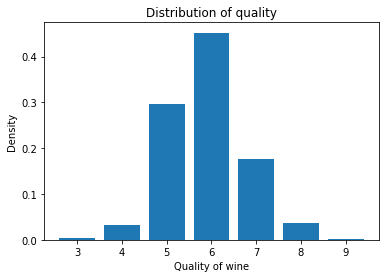

In [2]:
index, count = np.unique(y_train, return_counts = True)
plt.bar(index, count / len(y_train))
plt.xlabel("Quality of wine")
plt.ylabel("Density")
plt.title("Distribution of quality")
plt.show()

## Handin 2 

In [3]:
mean = y_train.mean()
train_squared_error = (y_train - mean) ** 2
test_squared_error = (y_test - mean) ** 2
print(f"Mean: {mean}, Training mean squared error {train_squared_error.mean()}, Test mean squared error: {test_squared_error.mean()}")

Mean: 5.878764675855028, Training mean squared error 0.7767772386501117, Test mean squared error: 0.8138573000045535


## Handin 3

In [4]:
def meanOf(X):
    return X.mean(axis = 0)

def varianceOf(X):
    X_center = X - meanOf(X)
    return np.sqrt((X_center ** 2).mean(axis = 0))

def standardise(X):
    mean, variance = meanOf(X), varianceOf(X)
    return ((X - mean) / variance), mean, variance

def standardise_with(X, mean, variance):
    return (X - mean) / variance

def mean_squared_error(y, y_est):
    return ((y - y_est) ** 2).mean()

def linear_model_error(X_train, y_train, X_test, y_test):
    N_train = len(X_train)
    N_test = len(X_test)
    
    # Standardise input
    X_train_std, mean, variance = standardise(X_train)
    X_test_std = standardise_with(X_test, mean, variance)

    # Add bias
    X_train_std_bias = np.insert(X_train_std, 0, np.ones(N_train), axis = 1)
    X_test_std_bias = np.insert(X_test_std, 0, np.ones(N_test), axis = 1)

    # Find parameter and estimates
    w = np.linalg.inv(X_train_std_bias.T @ X_train_std_bias) @ X_train_std_bias.T @ y_train
    y_train_estimated = X_train_std_bias @ w
    y_test_estimated = X_test_std_bias @ w

    # Computer error in training and testing
    train_error = mean_squared_error(y_train, y_train_estimated)
    test_error = mean_squared_error(y_test, y_test_estimated)
    return train_error, test_error


train_error, test_error = linear_model_error(X_train, y_train, X_test, y_test)
print(f"Training error: {train_error}, Test error: {test_error}")

Training error: 0.5639996173941925, Test error: 0.5607292042283468


Note that standardising is not necessary in this case because the closed form of the estimated parameter is not dependent on the mean or variance. However, we need to add bias to the model in order to make sure that the precision is not affected by translations.

## Handin 4

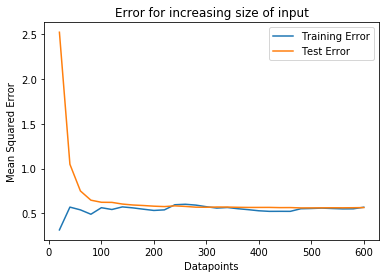

In [5]:
data_sizes = np.arange(20, 601, 20)
train_error = np.empty(len(data_sizes))
test_error = np.empty(len(data_sizes))

for i, data_size in enumerate(data_sizes):
    tre, tee = linear_model_error(X_train[:data_size], y_train[:data_size], X_test, y_test)
    train_error[i] = tre
    test_error[i] = tee
    
plt.plot(data_sizes, train_error, label = "Training Error")
plt.plot(data_sizes, test_error, label = "Test Error")
plt.xlabel("Datapoints")
plt.ylabel("Mean Squared Error")
plt.title("Error for increasing size of input")
plt.legend()
plt.show()

It seems that the training error and test error approach each other very fast and stay level even though we add more data. Therefore, I think that our model is underfitting. As it can be seen, these two errors get very close to each other after approximatively 100 iterations but the optimal error is reached on ~500th iteration.  

## Optional

In [6]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold

X, y = cp.load(open('winequality-white.pickle', 'rb'))

def estimator_error(X, y, X_val, y_val, model, degree = 2):
    X, y, X_val, y_val = X.copy(), y.copy(), X_val.copy(), y_val.copy()
    
    pipeline = make_pipeline(PolynomialFeatures(degree), StandardScaler(), model)
    
    pipeline.fit(X, y)
    y_est = pipeline.predict(X)
    y_val_est = pipeline.predict(X_val)
    return mean_squared_error(y, y_est), mean_squared_error(y_val, y_val_est)

def validation_parameter(name, model, alphas, dataset, final_dataset, tol = 0.001):
    X_main, y_main, X_validation, y_validation = dataset
    X, y, X_test, y_test = final_dataset
    
    best_alpha = -1
    best_error = 1e200
    
    for alpha in alphas:
        _, error = estimator_error(X_main, y_main, X_validation, y_validation, model(alpha, tol = tol))
        print(f"{name} error {error} for alpha {alpha}")
        if error < best_error:
            best_alpha, best_error = alpha, error
    
    train_error, test_error = estimator_error(X, y, X_test, y_test, model(best_alpha, tol = tol))
    print(f"Training error: {train_error}, Test error: {test_error} for {name} regression with alpha {best_alpha}")
    print()


# Build data
N_main = int(N_train * 0.8)
X_main = X_train[:N_main]
y_main = y_train[:N_main]
X_validation = X_train[:N_main]
y_validation = y_train[:N_main]
alphas = [1e-2, 1e-1, 1e0, 1e1, 1e2]

# Train with Ridge and Lasso regressions
dataset = (X_main, y_main, X_validation, y_validation)
final_dataset = (X_train, y_train, X_test, y_test)
validation_parameter("Ridge", Ridge, alphas, dataset, final_dataset)
validation_parameter("Lasso", Lasso, alphas, dataset, final_dataset)

Ridge error 0.4976658948620112 for alpha 0.01
Ridge error 0.5008726637568776 for alpha 0.1
Ridge error 0.5020783365622011 for alpha 1.0
Ridge error 0.5072043862844521 for alpha 10.0
Ridge error 0.523128235885675 for alpha 100.0
Training error: 0.501435447142948, Test error: 0.5161138844985275 for Ridge regression with alpha 0.01

Lasso error 0.5451507715134889 for alpha 0.01
Lasso error 0.6050022308686411 for alpha 0.1
Lasso error 0.7734672197676306 for alpha 1.0
Lasso error 0.7734672197676306 for alpha 10.0
Lasso error 0.7734672197676306 for alpha 100.0
Training error: 0.5489519598429463, Test error: 0.5422044237442246 for Lasso regression with alpha 0.01



## Super-optional

In [7]:
def cross_validation_parameter(name, model, alphas, dataset, n_splits = 5, degree = 3, tol = 0.001):
    X, y, X_test, y_test = dataset
    
    best_alpha = -1
    best_error = 1e200
    
    kfold = KFold(n_splits = n_splits)

    for alpha in alphas:
        cross_errors = []

        for train_data, test_data in kfold.split(X):
            X_main, y_main = X[train_data], y[train_data]
            X_validation, y_validation = X[test_data], y[test_data]
            _, error = estimator_error(X_main, y_main, X_validation, y_validation, 
                                       model(alpha, tol = tol), degree = degree)
            cross_errors.append(error)
            
        error = np.array(cross_errors).mean()
        if error < best_error:
            best_alpha = alpha
            best_error = error
            
        print(f"{name} error: {error} for alpha {alpha}")
    
    train_err, test_err = estimator_error(X, y, X_test, y_test, model(best_alpha, tol = tol), degree = degree)
    print(f"Training error: {train_err}, Test error: {test_err} for {name} regression with alpha {best_alpha}")
    print()

cross_validation_parameter("Ridge", Ridge, alphas, (X_train, y_train, X_test, y_test))
cross_validation_parameter("Lasso", Lasso, alphas, (X_train, y_train, X_test, y_test))

Ridge error: 0.8907810879342971 for alpha 0.01
Ridge error: 0.8302915661258001 for alpha 0.1
Ridge error: 0.7414819386612966 for alpha 1.0
Ridge error: 0.6062902295568089 for alpha 10.0
Ridge error: 0.5566313391166713 for alpha 100.0
Training error: 0.4947339958714718, Test error: 0.5086577649219994 for Ridge regression with alpha 100.0

Lasso error: 0.5761071048126567 for alpha 0.01
Lasso error: 0.6066118890077492 for alpha 0.1
Lasso error: 0.7771049866470655 for alpha 1.0
Lasso error: 0.7771049866470655 for alpha 10.0
Lasso error: 0.7771049866470655 for alpha 100.0
Training error: 0.5386614903472502, Test error: 0.5288907170323295 for Lasso regression with alpha 0.01

